In [11]:
import time
import os

# Main imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Start using selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

# Other imports
from GameLogic import *
from TreeLogic import *
from MCTSTreeLogic import *

Note that for this project, the source code for the game 2048 is used. The github repository by Gabriel Cirulli is available here: https://github.com/gabrielecirulli/2048

All external code used may be found in the folder labelled "2048"

In [12]:
################################
# USED FOR TESTING PURPOSES ONLY
################################
# s = blank()

# Test 1
# --------
# k=2
# for i in range(4):
#     for j in range(4):
#         s[i,j] = k
#         k *= 2
# s[0, 1] = 2
# --------

# Test 2
# --------
# s[1,1] = 2
# s[2,2] = 4
# --------

# startNode = State(s)
# Search(startNode, 100)

In [13]:
# Uses the safari web driver built into mac. Setup instructions for windows can be found here:
# https://selenium-python.readthedocs.io/installation.html
driver = webdriver.Safari()

In [14]:
path = os.path.abspath('../2048/index.html')
driver.get(f'file://{path}')
driver.maximize_window()

In [15]:
# Define a map from directions to selenium keys
dirKey = {
    'l' : Keys.ARROW_LEFT,
    'u' : Keys.ARROW_UP,
    'r' : Keys.ARROW_RIGHT,
    'd' : Keys.ARROW_DOWN
}

In [16]:
def gameToMatrix(d):
    # A function which takes a driver and translates the current game state
    # into a matrix which can be intepreted by Python. Takes a selenium driver d.
    retMat = blank()
    for tile in d.find_elements(By.CLASS_NAME, 'tile'):

        # Get the tile info from the web driver
        tileInfo = tile.get_attribute('class').split(' ')[2]
        tileRef = tileInfo.split('position-')[-1]
        c = [int(_) for _ in tileRef.split('-')]

        # Now, add the data to the matrix
        retMat[c[1] - 1, c[0] - 1] = int(tile.find_element(By.CLASS_NAME, 'tile-inner').text)

    return retMat

In [17]:
def getFinalScore():
    # Get the final score for this iteration
    finalScore = driver.find_element(By.CLASS_NAME, 'score-container').text

    # Map the final score so that it is an integer, and return the sum
    finalScore = finalScore.split('+')

    return sum([int(_) for _ in finalScore])

In [18]:
# A function to run some simulations of the Expectimax / Minimax algorithm
def simulateEM(dfLink, depths, epsilons, metric):

    # Loop through each combination
    for depth in depths:
        for epsilon in epsilons:

            print(f'Simulating depth of {depth} for exploration factor {epsilon} using {metric} tree search.')

            # Click the restart button after each run
            restartButton = driver.find_element(By.CLASS_NAME, 'restart-button')
            driver.execute_script("arguments[0].click();", restartButton)
            time.sleep(1)
            
            # Play the game using the specified simulation parameters
            while True:

                # Wait long enough for the board to be updated
                time.sleep(0.5)

                # Store the game state in the class instance
                node = Node(gameToMatrix(driver))
                node.expand(depth, epsilon, metric)

                # Store the next possible scores
                d = node.nextScores

                # Terminate if empty
                if len(d) == 0: break

                # Maximise to decide the next move
                nextMove = max(d, key=d.get)

                # Play the move
                driver.find_element(By.CLASS_NAME, 'container').send_keys(dirKey[nextMove])

            # Store the statistics
            newEntry = {
                'depth' : depth,
                'epsilon' : epsilon,
                'metric' : metric,
                'score' : getFinalScore(),
                'largestTile' : np.max(gameToMatrix(driver))
            }

            # Store the data so that it is not lost on crash
            df = pd.DataFrame(pd.Series(newEntry)).T
            df.to_csv(dfLink, mode='a', index=False, header=False)

    # Quit once finished
    driver.quit()

In [19]:
# A function to run some simulations of the Expectimax / Minimax algorithm
def simulateMCTS(dfLink, simulationList, depthList):

    # Loop through each combination
    for simulations in simulationList:
        for depth in depthList:

            print(f'Simulating depth of {depth} for {simulations} simulations.')

            # Click the restart button after each run
            restartButton = driver.find_element(By.CLASS_NAME, 'restart-button')
            driver.execute_script("arguments[0].click();", restartButton)
            time.sleep(1)
            
            # Play the game using the specified simulation parameters
            while True:

                # Wait long enough for the board to be updated
                time.sleep(0.5)

                # Store the current state as a grid
                startNode = State(gameToMatrix(driver))

                # Check if we are losing
                if startNode.losing: break

                # Calculate the start node
                nextMove = Search(startNode, simulations, depth)

                # Play according to the argmax
                driver.find_element(By.CLASS_NAME, 'container').send_keys(dirKey[nextMove])

            # Store the statistics
            newEntry = {
                'simulations' : simulations,
                'depth' : depth,
                'score' : getFinalScore(),
                'largestTile' : np.max(gameToMatrix(driver))
            }

            # Store the data so that it is not lost on crash
            df = pd.DataFrame(pd.Series(newEntry)).T
            df.to_csv(dfLink, mode='a', index=False, header=False)

    # Quit once finished
    driver.quit()

In [20]:
# Use this for Expectimax / Minimax
# simulateEM('minimaxResults.csv', [0,1,2], [0.1, 0.2, 0.3], 'expectimax')

# Use this for Monte-Carlo Tree Search
simulateMCTS('mctsResults.csv', [10, 100, 200], [1, 10, 50])

Simulating depth of 1 for 10 simulations.
Simulating depth of 10 for 10 simulations.
Simulating depth of 50 for 10 simulations.
Simulating depth of 1 for 100 simulations.
Simulating depth of 10 for 100 simulations.
Simulating depth of 50 for 100 simulations.
Simulating depth of 1 for 200 simulations.
Simulating depth of 10 for 200 simulations.


KeyboardInterrupt: 

In [ ]:
# Use this to quit the driver if necessary
# driver.quit()

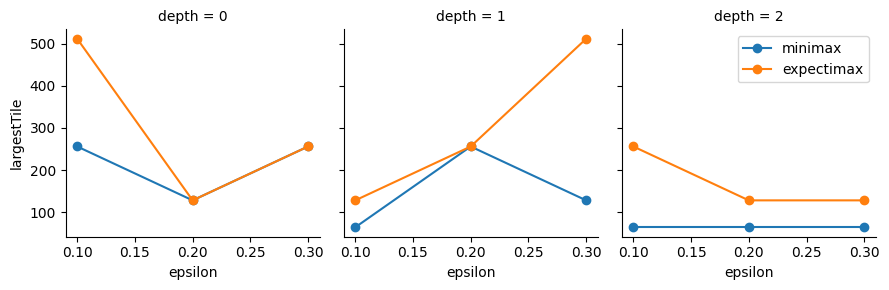

In [ ]:
dfEM = pd.read_csv('minimaxResults.csv')
grid = sns.FacetGrid(dfEM, col='depth', hue='metric')
grid.map(plt.plot, 'epsilon', 'largestTile', marker='o')
plt.legend();

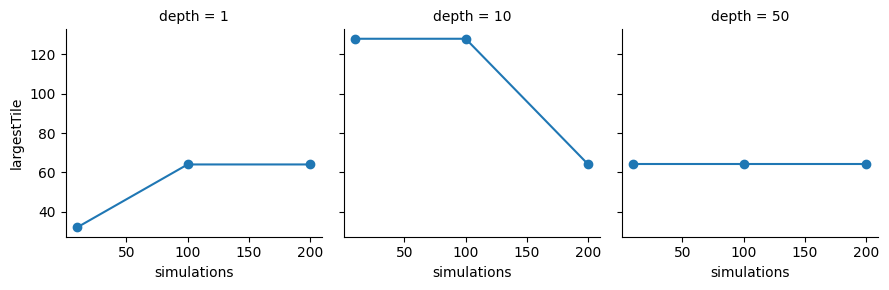

In [ ]:
dfMCTS = pd.read_csv('mctsResults.csv')
grid = sns.FacetGrid(dfMCTS, col='depth')
grid.map(plt.plot, 'simulations', 'largestTile', marker='o');